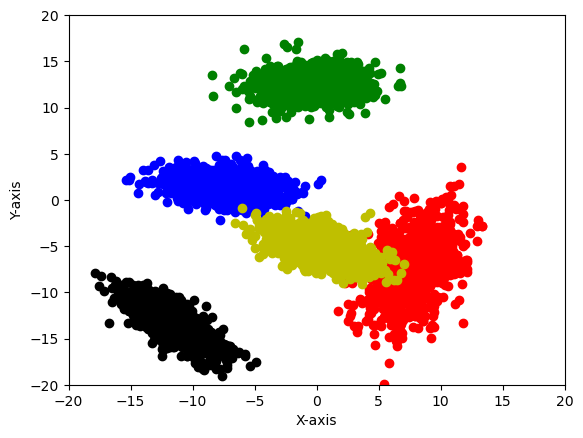

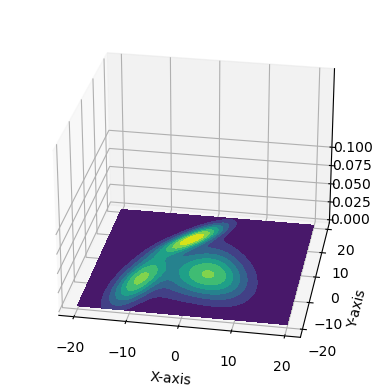

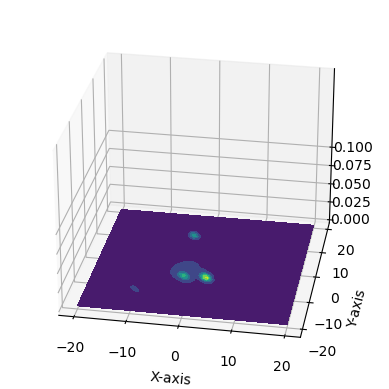

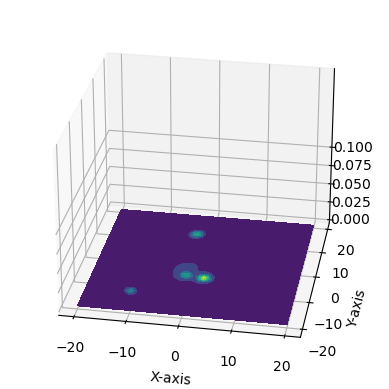

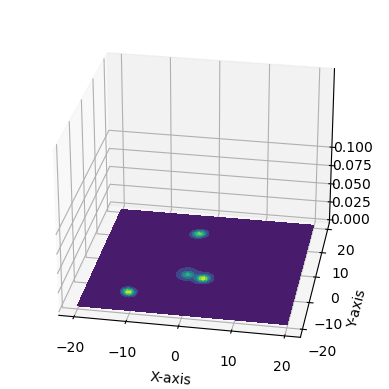

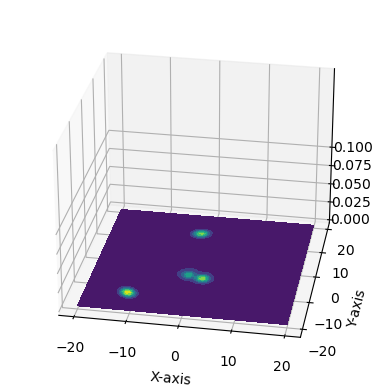

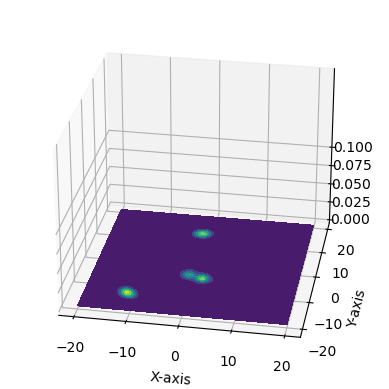

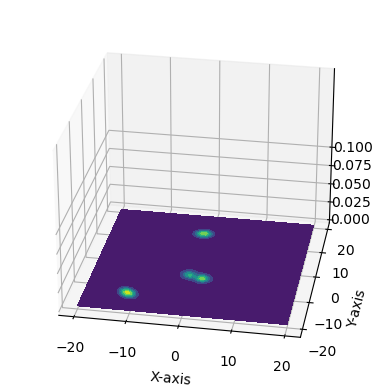

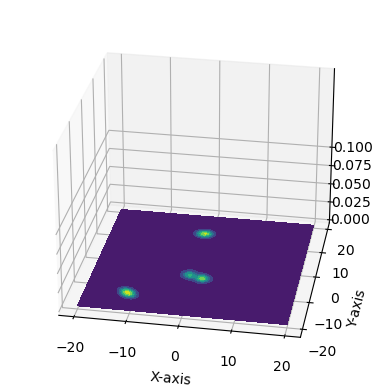

3D Plot of Trained GMM


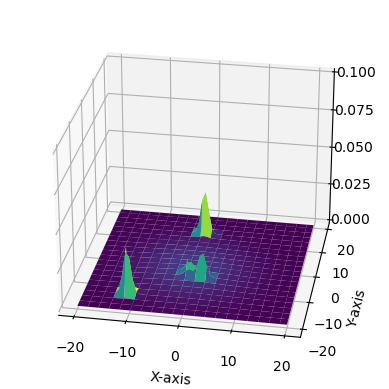

Final Contour Plot


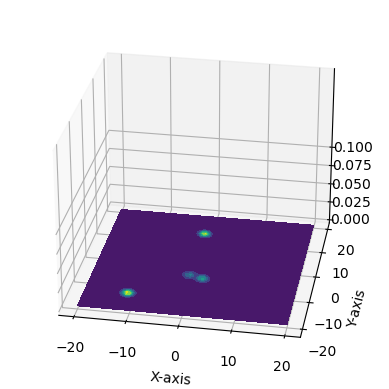

Number of iterations run: 8


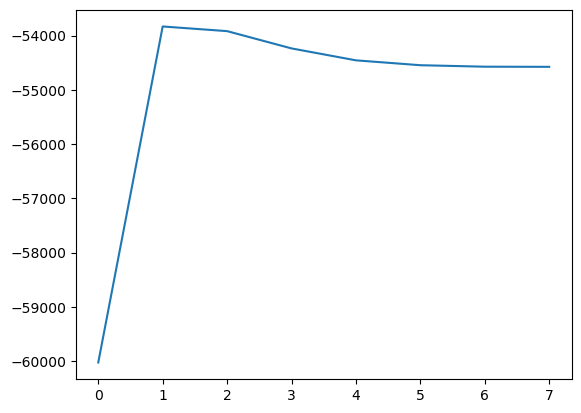

In [16]:
import random  
import numpy as np 
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


from mpl_toolkits.mplot3d import Axes3D

# Re-Used from Project 01 (K-Means Algorithm)
def generate_dataset(no_of_clusters, no_of_points_per_cluster): 
 
    # Creates an empty array to store the clusters 
    my_array = [0] * no_of_clusters 

    cluster_colors = ['r', 'g', 'b', 'y', 'black', 'purple'] 

    #Creates 2D clusters with the desired number of points per cluster 
    for index in range(no_of_clusters): 
        cluster = np.random.randn(no_of_points_per_cluster, 2) 
 
        # Sets the current array index to the created cluster 
        my_array[index] = np.array(cluster) 
    

    # Applys scaling, shifting, and rotations to all clusters 
    for index in range(no_of_clusters): 
        # Creates matrix for scaling 
        scaling_a = round(random.uniform(0, 1), 2) 
        scaling_b = round(random.uniform(2, 1), 2) 
        scaling_c = round(random.uniform(2, 3), 2) 
        scaling_d = round(random.uniform(0, 1), 2) 

        scaling = np.array([[scaling_a, scaling_b], [scaling_c, scaling_d]]) 

        # Stores dot product between cluster and scaled matrix 
        scaled_data = (my_array[index]).dot(scaling) 

        # Upper bound for rotation 
        upper_bound = math.pi*2 

        # Random value for rotating from 0 to upper bound with 5 decimal points 
        random_rotation = round(random.uniform(0, upper_bound), 5) 

        # Converts random rotation to sin and cos values 
        cos = math.cos(random_rotation) 
        sin = math.sin(random_rotation) 

        # Creates matrix based off random rotation value and stores the  
        # dot product 
        rotate_matrix = np.array([[cos, -sin], [sin, cos]]) 

        rotated_data = scaled_data.dot(rotate_matrix.T) 

        # Random cluster shifted values 
        random_shift_x = round(random.uniform(-15, 15), 5) 
        random_shift_y = round(random.uniform(-15, 15), 5) 

        shift_matrix = np.array([random_shift_x, random_shift_y]) 

        # Shifts cluster by taking the dot product of cluster with shifted  
        # matrix values 
        shifted_data = rotated_data.dot(rotate_matrix.T) + shift_matrix 

        # Stores new transfromed cluster in array of clusters 
        my_array[index] = np.array(shifted_data) 

    # Displays the clusters 
    for index in range(no_of_clusters): 
        plt.scatter(my_array[index][:, 0], my_array[index][:, 1], color = cluster_colors[index]) 
        
    plt.xlim(-20, 20)  # Set x-axis range from 0 to 1
    plt.ylim(-20, 20)  # Set y-axis range from 0 to 4

    # Add labels and a legend
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show() 

    # Concatenates all clusters into a single matrix and returns it 
    data_matrix = np.concatenate(my_array, axis = 0) 

    return data_matrix 

# Designed by Jarrod Flanders
def EM_uwplatt_init(no_of_components, data_matrix):
    
    data_matrix_mean_x = 0
    data_matrix_mean_y = 0
    
    #Add all of the x and y components of the data_matrix to get 
    for i in range (0, len(data_matrix)):
        data_matrix_mean_x = data_matrix_mean_x + data_matrix[i][0]
        data_matrix_mean_y = data_matrix_mean_y + data_matrix[i][1]
        
    # Average for x and y components of data_matrix    
    data_matrix_mean_x = data_matrix_mean_x/len(data_matrix) 
    data_matrix_mean_y = data_matrix_mean_y/len(data_matrix) 
    
    # Initiliazes mean matrix
    mean_matrix = np.zeros((no_of_components, 2))
    
    # Sets mean vectors by using a random off set based around the data_matrix mean
    for j in range (0, len(mean_matrix)):
        mean_matrix[j][0] = data_matrix_mean_x + random.randrange(-30, 30)
        mean_matrix[j][1] = data_matrix_mean_y + random.randrange(-30, 30)
    
    # Initiliazes components covariance matrix
    cov_matrix = np.zeros((2*no_of_components, 2))
    
    # Covariance matrix of data_matrix
    cov_data_matrix = np.cov(data_matrix, rowvar = False)
    
    # Sets the data covariance matrix as the covariance matrix for all components
    for i in range (0, len(cov_matrix)): 
        if (i % 2 == 0):
            cov_matrix[i][0] = cov_data_matrix[0][0]
            cov_matrix[i][1] = cov_data_matrix[0][1]
        else:
            cov_matrix[i][0] = cov_data_matrix[1][0]
            cov_matrix[i][1] = cov_data_matrix[1][1]
            
    # Initiliazes component weights 
    component_weights_matrix = np.zeros((1, no_of_components))
    
    # Sets the components weights uniformly
    for k in range (0, no_of_components):
        component_weights_matrix[0][k] = 1 / no_of_components   
    # Setup extended matrix filled with zeros    
    extended_matrix = np.zeros((len(data_matrix), 2 + no_of_components))   
    
    # Sets the data portion of the extended matrix
    for i in range (0, len(data_matrix)): 
        extended_matrix[: ,0] = data_matrix[:,0] 
        extended_matrix[:, 1] = data_matrix[:,1] 

    return extended_matrix, mean_matrix, cov_matrix, component_weights_matrix

# Designed by Jarrod Flanders
def EM_uwplatt_expectation(extended_matrix, mean_matrix, cov_matrix, component_weights_matrix):
    
    # gets all samples x and y coordinates and concatenates them 
    subset = extended_matrix[:, 0:2] 
       
    # Vars to keep track of likelihoods for samples for each component
    sample_likelihood_component = np.zeros((len(extended_matrix), len(component_weights_matrix[0])))   
    sample_likelihood_GMM = np.zeros((len(extended_matrix), 1))
    
    for i in range(0, len(component_weights_matrix[0])):   
        #Calculates likelihood that sample comes from each component
        sample_likelihood_component[:,i] = component_weights_matrix[0][i] * (multivariate_normal.pdf(subset[:], mean_matrix[i], cov_matrix[i*2:i*2+2, :]))
    
    for i in range(0, len(extended_matrix)):  
        for j in range(0, len(component_weights_matrix[0])):
            # Calculates sum of all likelihoods for each component
            sample_likelihood_GMM[i][0] = np.sum(sample_likelihood_component[i,:])
        
            # Puts the membership weight into the extended matrix
            extended_matrix[i, 2 + j] = sample_likelihood_component[i,j]/sample_likelihood_GMM[i][0]
   
    return extended_matrix

# Designed by Brody Horton and Jarrod Flanders 
def EM_uwplatt_maximization(extended_matrix, mean_matrix, cov_matrix, component_weights_matrix):
       
    new_mean_matrix = np.zeros((len(component_weights_matrix[0]), 2))

    for c in range(0, len(component_weights_matrix[0])):   
        #Multiply each sample by their membership weight for that component and sum them up
        new_mean_matrix[c][0] = (np.sum(extended_matrix[:,2+c] * extended_matrix[:, 0]))/np.sum(extended_matrix[:, 2 + c])
        new_mean_matrix[c][1] = (np.sum(extended_matrix[:,2+c] * extended_matrix[:, 1]))/np.sum(extended_matrix[:, 2 + c])
  
    for c in range(0, len(component_weights_matrix[0])):
        # Sigma_x,x top right value of cov_matrix
        cov_matrix[2*c][0] = (np.sum(extended_matrix[:, 2 + c] * ((extended_matrix[:,0] - new_mean_matrix[c,0]) ** 2))) / np.sum(extended_matrix[:, 2 + c])
       
        # Sigma_x,y   
        cov_matrix[2*c][1] = (np.sum(extended_matrix[:, 2 + c] * ((extended_matrix[:,0] - new_mean_matrix[c,0]) * (extended_matrix[:,1] - new_mean_matrix[c,1])))) / np.sum(extended_matrix[:, 2 + c])
                              
        # Sigma_y,x equals Sigma_x,y
        cov_matrix[2*c+1][0] = cov_matrix[2*c][1]
               
        # Sigma_y,y                      
        cov_matrix[2*c+1][1] = (np.sum(extended_matrix[:, 2 + c] * ((extended_matrix[:,1] - new_mean_matrix[c,1]) ** 2))) / np.sum(extended_matrix[:, 2 + c])
                                                                    
        component_weights_matrix[0][c] = (np.sum(extended_matrix[:, 2 + c])) / len(extended_matrix)
        
    return new_mean_matrix, cov_matrix, component_weights_matrix

# Designed by Jarrod Flanders  
def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N    

# Designed by Brody Horton and Jarrod Flanders
def EM_uwplatt_contour_plot(mean_matrix, cov_matrix, component_weights_matrix):
    # Our 2-dimensional distribution will be over variables X and Y
    N = 60 # Number of ticks on X, Y axes
    X = np.linspace(-20, 20, N)
    Y = np.linspace(-20, 20, N)
    X, Y = np.meshgrid(X, Y)
    
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,)) # size (N, N, 2)
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
       
    z_components = []
    
    #initialize 5 index with 60x60 array
    for i in range(len(component_weights_matrix[0])):     
        z_components.append(np.zeros((60, 60)))
     
    # The distribution over the variables X, Y packed into pos
    for i in range(0, len(component_weights_matrix[0])):
        z_components[i][:] = multivariate_gaussian(pos, mean_matrix[i, :], cov_matrix[i*2:i*2+2, :])
         
    Z = 0
       
    #Sum of the weight and Sum Gaussian Components
    for i in range(0, len(component_weights_matrix[0])):
        Z += z_components[i][:] * component_weights_matrix[0][i]
   
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    cset = ax.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Adjust the limits, ticks and view angle
    ax.set_zlim(0,0.2)
    ax.set_zticks(np.linspace(0,0.1,5))
    ax.view_init(27, -80)
    plt.show()
      

# Designed by Brody Horton and Jarrod Flanders
def EM_uwplatt_dataset_log_likelihood(extended_matrix, mean_matrix, cov_matrix, component_weights_matrix):
    
    dataset_log_likelihood = 0.0
         
    for i in range(0, len(extended_matrix)):  
        temp = 0.0
        for j in range(0, len(component_weights_matrix[0])): 
            temp += component_weights_matrix[0][j] * (multivariate_normal.pdf(extended_matrix[i, 0:2], mean_matrix[j], cov_matrix[j*2:j*2+2, :]))
        
        dataset_log_likelihood += np.log(temp)
      
    return dataset_log_likelihood
    
# Designed by Caleb Moore
def EM_uwplatt_test_convergence(dataset_log_likelihood_prev, dataset_log_likelihood_current, plateauCounter):
    arbitraryThreshold = 30
    arbitraryValue = 5

    diff = dataset_log_likelihood_current - dataset_log_likelihood_prev 
    
    if diff < arbitraryThreshold:
        plateauCounter += 1
    else:
        plateauCounter = 0
    if plateauCounter > arbitraryValue:
        isConverged = 1
        return isConverged, plateauCounter
    else:
        isConverged = 0
        return isConverged, plateauCounter
    
# Designed by Dayton Ellis
def EM_uwplatt(data_matrix, no_of_components):
    
    # Setting initial variable values for convergence flag and interation values.
    isConverged = 0
    plateauCounter = 0
    dataset_log_likelihood_matrix = []
    
    # Running inititialization function on initial dataset.
    extended_matrix, mean_matrix, cov_matrix, component_weights_matrix = EM_uwplatt_init(no_of_components, data_matrix)
    # Begin running main cycling loop for GMM.
    while True:
        # Making initial calculations based on 
        extended_matrix = EM_uwplatt_expectation(extended_matrix, mean_matrix, cov_matrix, component_weights_matrix)
        mean_matrix, cov_matrix, component_weights_matrix = EM_uwplatt_maximization(extended_matrix, mean_matrix, cov_matrix, component_weights_matrix)
        
        # Printing contour plot based on calculations made above.
        EM_uwplatt_contour_plot(mean_matrix, cov_matrix, component_weights_matrix)
        
        # Determining the log likelihood matrix based on the current dataset.
        dataset_log_likelihood_matrix.append(EM_uwplatt_dataset_log_likelihood(extended_matrix, mean_matrix, cov_matrix, component_weights_matrix))
        
        # Check for convergence flag, break out of cycle if met.
        isConverged, plateauCounter = EM_uwplatt_test_convergence(dataset_log_likelihood_matrix[len(dataset_log_likelihood_matrix) - 2], dataset_log_likelihood_matrix[len(dataset_log_likelihood_matrix) - 1], plateauCounter)
        
        if isConverged != 0:
            break
            
    return mean_matrix, cov_matrix, component_weights_matrix, dataset_log_likelihood_matrix

# Designed by Dayton Ellis and Jarrod Flanders
def plotGMM(mean_matrix, cov_matrix, component_weights_matrix):
    
    # Our 2-dimensional distribution will be over variables X and Y
    N = 60 # Number of ticks on X, Y axes
    X = np.linspace(-20, 20, N)
    Y = np.linspace(-20, 20, N)
    X, Y = np.meshgrid(X, Y)
    
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,)) # size (N, N, 2)
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    z_components = []
    
    #initialize 5 index with 60x60 array
    for i in range(len(component_weights_matrix[0])):     
        z_components.append(np.zeros((60, 60)))
     
    # The distribution over the variables X, Y packed into pos
    for i in range(0, len(component_weights_matrix[0])):
        z_components[i][:] = multivariate_gaussian(pos, mean_matrix[i, :], cov_matrix[i*2:i*2+2, :])
         
    Z = 0
       
    #Sum of the weight and Sum Gaussian Components
    for i in range(0, len(component_weights_matrix[0])):
        Z += z_components[i][:] * component_weights_matrix[0][i]
   
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Adjust the limits, ticks and view angle
    ax.set_zlim(0,0.1)
    ax.set_zticks(np.linspace(0,0.1,5))
    ax.view_init(27, -80)
    plt.show()
    

# Designed by Dayton Ellis and Jarrod Flanders
def main(): 
    
    # Generating the initial synthetic dataset being observed throughout the process.
    # Will be 4 clusters of data with 1000 entries apiece.
    data_matrix = generate_dataset(5, 1000) 
    
    # Running main loop for the Gaussian Mixture Model algorithm.
    mean_matrix, cov_matrix, component_weights_matrix, dataset_log_likelihood_matrix = EM_uwplatt(data_matrix, 5)

    # Generating 3D plot of trained GMM and its final contour plot.
    print("3D Plot of Trained GMM")
    plotGMM(mean_matrix, cov_matrix, component_weights_matrix)
    
    print("Final Contour Plot")
    EM_uwplatt_contour_plot(mean_matrix, cov_matrix, component_weights_matrix)
    
    #Type cast int to string
    iterations = str(len(dataset_log_likelihood_matrix))
    
    # Final number of iterations run
    print("Number of iterations run: " + iterations)
    
    # Trend plot of dataset likelihood over iterations
   # plt.scatter(dataset_log_likelihood_matrix, x="Iteration", y="Likelihood")
   
    fig = plt.figure()
    plt.plot(dataset_log_likelihood_matrix);
    plt.show()
    
    
 
# Call to main function, initiates program 
if __name__ == "__main__": 

    main()  